In [19]:
import os
import sys
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import multivariate_normal,beta,dirichlet
from math import log
%matplotlib inline
plt.style.use('ggplot')
np.random.seed(1234)
from scipy.special import gamma
import ternary


np.set_printoptions(formatter={'all':lambda x: '%.3f' % x})

In [3]:
a1 = 50
a2 = 50
a3 = 50
beta = gamma(a1)*gamma(a2)*gamma(a3)/gamma(a1+a2+a3)

In [8]:
x0 = np.linspace(0,1,num=100)
x1 = x0
x2 = x0
x3 = x0
# y = np.zeros((len(x1),len(x2),len(x3)))
y = dict()


In [ ]:
# start = 0
# scale = 10
# for i in range(start, scale + (1 - start)):
#     for j in range(start, scale + (1 - start) - i):
#         k = scale - i - j
#         print(i, j, k)

In [25]:
for i in range(len(x1)):
    for j in range(len(x2)):
        for k in range(len(x3)):
            if np.absolute(x1[i]+x2[j]+x3[k]-1)<1e-5:
                # print(i,j,k)
                y[(x1[i], x2[j])] = x1[i]**(a1-1) * x2[j]**(a2-1) * x3[k]**(a3-1)/beta

In [5]:
def f(x):
    return x[0]**(a1-1) * x[1]**(a2-1) * x[2]**(a3-1)/beta

In [ ]:
scale = 60
fig, tax = ternary.figure(scale=scale)
tax.heatmapf(f,scale=scale)

In [ ]:
# def shannon_entropy(p):
#     """Computes the Shannon Entropy at a distribution in the simplex."""
#     s = 0.
#     for i in range(len(p)):
#         try:
#             s += p[i] * log(p[i])
#         except ValueError:
#             continue
#     return -1.*s
# scale = 60

# figure, tax = ternary.figure(scale=scale)
# tax.heatmapf(shannon_entropy, boundary=True, style="triangular")
# tax.boundary(linewidth=2.0)
# tax.set_title("Shannon Entropy Heatmap")

# tax.show()

In [90]:
b1 = beta.rvs(1,5,size=50)
b2 = beta.rvs(20,2,size=50)
b3 = np.hstack((b1,b2))

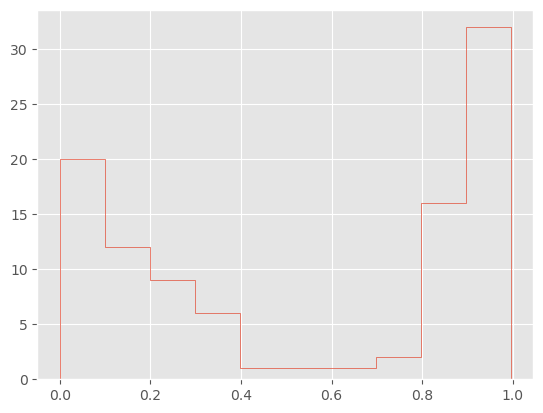

In [92]:
plt.figure()
counts, bins = np.histogram(b3)
plt.stairs(counts, bins)
# plt.hist(b3,bins=10)

In [113]:
alpha_0 = np.ones((10))*2
alpha_1 = alpha_0 + counts
d = dirichlet.rvs(alpha_1,size=100)
pred = d/0.1
counts_pred = np.sum(d,axis=0)

In [114]:
print(counts_pred)

[18.524 11.973 8.437 6.417 2.648 2.525 2.353 3.489 15.193 28.441]


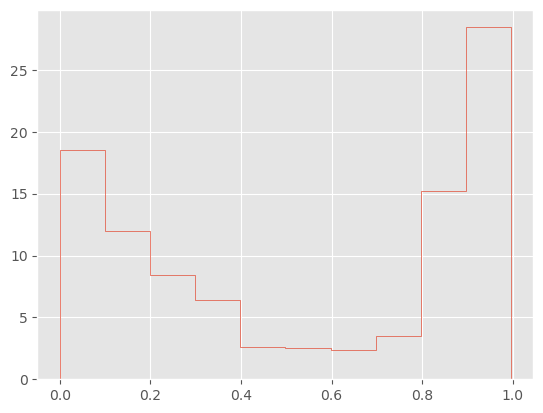

In [117]:
plt.figure()
plt.stairs(counts_pred,bins)